In [1]:
import sklearn
from sklearn.manifold import TSNE
import torch
import numpy as np
import os
import random
from improved_diffusion.unet import style_encoder_textedit_addskip
from PIL import Image
from scripts.image_sample import resize_image
from matplotlib import pyplot as plt

In [45]:
from torch import nn
import torch.nn.functional as F

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg19cut': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'N'],
}

class StyleEncoder(nn.Module):
    def __init__(self, sty_dim=128):
        super(StyleEncoder, self).__init__()
        # network layers setting
        self.features = make_layers(cfg['vgg11'], True)
        self.cont = nn.Linear(512, sty_dim)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        flat = x.view(x.size(0), -1)
        cont = self.cont(flat)

        return cont

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=False)]
            else:
                layers += [conv2d, nn.ReLU(inplace=False)]
            in_channels = v
    return nn.Sequential(*layers)

In [3]:
style_encoder = style_encoder_textedit_addskip()
style_encoder_state_dict = torch.load("models/CFG/checkpoint_epoch6.pth",map_location='cpu')['netStyleEncoder']
style_encoder.load_state_dict(style_encoder_state_dict)

#style_encoder = StyleEncoder()
# checkpoint = torch.load("chinese_styenc.ckpt", map_location='cpu')
# tmp_dict = {}
# for k, v in checkpoint.items():
#     if k in style_encoder.state_dict():
#         tmp_dict[k] = v
# style_encoder.load_state_dict(tmp_dict)
#
style_encoder.to(torch.device("cuda:0"))


Param count for Ds initialized parameters: 20591296


style_encoder_textedit_addskip(
  (activation): ReLU()
  (blocks): ModuleList(
    (0): ModuleList(
      (0): DBlock(
        (activation): ReLU()
        (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (conv1): SNConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): SNConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_sc): SNConv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): ModuleList(
      (0): DBlock(
        (activation): ReLU()
        (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (conv1): SNConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): SNConv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_sc): SNConv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): ModuleList(
      (0): DBlock(
        (activation): ReLU()
        (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0

In [63]:
style_num = np.linspace(0,10,10,dtype=np.int64)
num_image_per_style = 500
style_encoding_list = []
style_encoding_tag = []
for style_index in style_num:
    style_path = os.path.join("datasets/CFG/seen_font500_800",str(style_index))
    available_characters_with_ext = os.listdir(style_path)
    chosen = random.choices(available_characters_with_ext,k=num_image_per_style)
    for i in range(num_image_per_style):
        gt_image = Image.open(os.path.join(style_path, chosen[i]))
        gt_image = resize_image(gt_image,128).to(torch.device("cuda:0")).unsqueeze(0)
        #print(gt_image.shape)
        _,out,_ = style_encoder(gt_image)
        #print(out.shape)
        style_encoding_list.append(out.detach())
        style_encoding_tag.append(style_index)

In [64]:
style_encoding = torch.stack(style_encoding_list).cpu().squeeze()
tags = []
encodings = []
for start in range(0,5000,500):
    tag = style_encoding_tag[start]
    print(tag)
    mu = torch.mean(style_encoding[start:start+500,:],dim=0)
    print(mu.shape)
    std = torch.std(style_encoding[start:start+500,:],dim = 0)
    print(std.shape)
    new = []
    for pt in style_encoding[start:start+500,:]:
        if torch.norm(pt-mu) < torch.norm(std)*0.9:
            new.append(pt)
    print(len(new))
    tags.extend([tag]*len(new))
    encodings.extend(new)
encodings = torch.stack(encodings).cpu().squeeze()
print(len(tags))
print(encodings.shape)

0
torch.Size([1024])
torch.Size([1024])
131
1
torch.Size([1024])
torch.Size([1024])
131
2
torch.Size([1024])
torch.Size([1024])
145
3
torch.Size([1024])
torch.Size([1024])
154
4
torch.Size([1024])
torch.Size([1024])
140
5
torch.Size([1024])
torch.Size([1024])
109
6
torch.Size([1024])
torch.Size([1024])
153
7
torch.Size([1024])
torch.Size([1024])
151
8
torch.Size([1024])
torch.Size([1024])
133
10
torch.Size([1024])
torch.Size([1024])
146
1393
torch.Size([1393, 1024])


In [65]:

tsne = TSNE()
tsne_out = tsne.fit_transform(encodings)

In [66]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
 
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

In [67]:
print(tsne_out.shape)

(1393, 2)


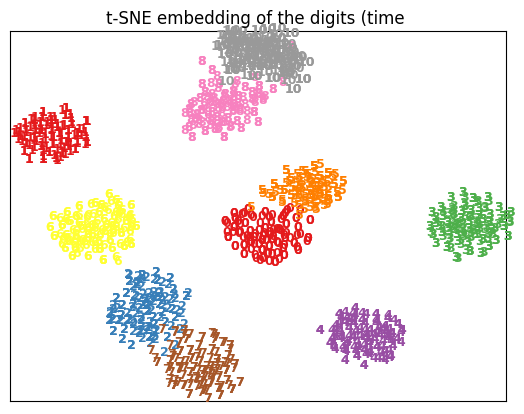

In [68]:


fig = plot_embedding(tsne_out, tags,
                         't-SNE embedding of the digits (time ')
plt.show(fig)

In [8]:
"""
Generate a large batch of image samples from a model and save them as a large
numpy array. This can be used to produce samples for FID evaluation.
"""

import argparse
import os
import numpy as np
import torch as th
import torch.distributed as dist

from PIL import Image
import torchvision.transforms as transforms
import blobfile as bf

from improved_diffusion import dist_util, logger
from improved_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
)

import json
import math
import random
from improved_diffusion.image_datasets import ImageDataset
def main():
    args = create_argparser().parse_known_args()[0]
    # Generate picture according to model names
    args_dict = vars(args)
    model_name = args_dict["model_name"]
    style_path = args_dict["data"]["style_path"]
    style_num = style_path.split('/')[-1]
    src = style_path.split('/')[-2]
    # Allow it to generate result for a specific model for multiple times
    i = 1
    if args_dict["model"]["params"]["timestep_respacing"] == '':
        timestep_respacing = "f"
    else:
        timestep_respacing = args_dict["model"]["params"]["timestep_respacing"]
    logger_path = os.path.join(args_dict["path"],"".join(model_name.split(".")[:-1])+"_"+src+"_"+style_num+"_"+timestep_respacing+"_"+str(i))
    while os.path.exists(logger_path):
        i += 1
        logger_path = os.path.join(args_dict["path"],"".join(model_name.split(".")[:-1])+"_"+src+"_"+style_num+"_"+timestep_respacing+"_"+str(i))
    # Init dist
    dist_util.setup_dist()
    logger.configure(logger_path)

    logger.log("creating model and diffusion...")
    model, diffusion = create_model_and_diffusion(**args_dict["model"]["params"])
    model.load_state_dict(
        dist_util.load_state_dict(os.path.join(args_dict["path"],model_name), map_location="cpu")
    )
    model.to(dist_util.dev())
    model.eval()

    # with open(args.characters,'r') as f:
    #     characters = json.load(f)
    # content_names = []
    # for file in [bf.basename(namepath).split("_")[0] for namepath in bf.listdir(args.style_path)]:
    #     if file.split('.')[0] in char_800:
    #         content_names.append(file)

    #sorted_classes = {x: i for i, x in enumerate(sorted(set(content_names)))}
    available_characters_with_ext = os.listdir(style_path)
    logger.log("sampling...")
    all_images = []
    all_gt_images = []
    all_content = []
    all_style_images = []
    all_strokes = []
    #
    if args_dict["model"]["params"]["unet_config"]["use_stroke"]:
        stroke_path = "datasets/CFG/new_strokes.json"
        with open(stroke_path,'r') as f:
            strokes = json.load(f)
            stroke_part_list = [
            "㇔",# 点 \u31d4
            "㇐",# 横 \u31d0
            "㇑",# 竖 \u31d1
            "㇓",# 撇 \u31d3
            "㇏",# 捺 \u31cf
            "㇀",# 提 \u31c0
            "𡿨",# 撇点 \ud847\udfe8
            "㇙",# 竖提 \u31d9
            "㇊",# 横折提 \u31ca
            "㇁",# 弯钩 \u31c1
            "㇚",# 竖钩 \u31da
            "㇟",# 竖弯钩 \u31df
            "㇂",# 斜钩 \u31c2
            "㇃",# 卧钩 \u31c3
            "㇖",# 横沟 \u31d6
            "㇆",# 横折钩 \u31c6
            "㇈",# 横折弯钩 \u31c8
            "㇌",# 横撇弯钩 \u31cc
            "㇡",# 横折折折钩 \u31e1
            "㇉",# 竖折折钩 \u31c9
            "㇗",# 竖弯 \u31d7
            "㇍",# 横折弯 \u31cd
            "㇕",# 横折 \u31d5
            "𠃊",# 竖折 \ud840\udcca
            "ㄥ",# 撇折 \u3125
            "㇇",# 横撇 \u31c7
            "㇋",# 横折折撇 \u31cb
            "ㄣ",# 竖折撇 \u3123
            "⺄",# 横斜钩 \u2e84
            "㇞",# 竖折折 \u31de
            "㇅",# 横折折 \u31c5
            "㇎" # 横折折折 \u31ce
            ]
    #
    # TODO There's a bug if the program enters the loop for more than one time
    # while len(all_images) * args_dict["data"]["batch_size"] < args.num_samples:
    model_kwargs = {}
    # if args.class_cond:
    #     pass
        # classes = th.randint(
        #     low=0, high=400, size=(args.batch_size,), device=dist_util.dev()
        # )
        #classes = th.tensor(range(args.batch_size),device=dist_util.dev())
        #classes = th.tensor(np.array([5209,4777,218,1964,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31])).to(dist_util.dev())
    #else:
        # for character in characters:
        #     for key, value in sorted_classes.items():
        #         if int(index) == value:
        #             all_label_names.append(key)
    characters_to_generate_with_ext = random.sample(available_characters_with_ext,args_dict["data"]["batch_size"])
    for character_with_ext in characters_to_generate_with_ext:
        character = character_with_ext.split('.')[0]
        all_content.append(ord(character))
        # Get GT image
        try:
            gt_image = Image.open(os.path.join(style_path, character_with_ext))
        except:
            gt_image = Image.fromarray(np.zeros((256,256)))
        all_gt_images.append(gt_image)
        

        # Get Style image randomly
        style_image = random.choice(available_characters_with_ext)
        style_image = Image.open(os.path.join(style_path, style_image))
        style_image = resize_image(style_image,128)
        all_style_images.append(style_image.unsqueeze(0))

        # Get stroke
        if args_dict["model"]["params"]["unet_config"]["use_stroke"]:
            char_strokes = strokes[character]
            stroke_count_dict = dict([(stroke_part,0) for stroke_part in stroke_part_list])
            for stroke in char_strokes:
                stroke_count_dict[stroke] += 1
            char_stroke_list = []
            for stroke in stroke_part_list:
                char_stroke_list.append(stroke_count_dict[stroke])
            all_strokes.append(np.array(char_stroke_list,dtype=np.float32))
        
    model_kwargs["content_text"] = th.tensor(all_content, dtype=th.int64).to(dist_util.dev())
    model_kwargs["style_image"] = th.cat(all_style_images, dim=0).to(dist_util.dev())
    if args_dict["model"]["params"]["unet_config"]["use_stroke"]:
        model_kwargs["stroke"] = th.tensor(np.array(all_strokes)).to(dist_util.dev())
    
    sample_fn = (
        diffusion.p_sample_loop if not args_dict["sampler"]["use_ddim"] else diffusion.ddim_sample_loop
    )
    sample = sample_fn(
        model,
        (args_dict["data"]["batch_size"] , 3, args_dict["model"]["params"]["unet_config"]["image_size"], args_dict["model"]["params"]["unet_config"]["image_size"]),
        clip_denoised=args_dict["sampler"]["clip_denoised"],
        model_kwargs=model_kwargs,
        progress=True
    )
    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()

    #gathered_samples = [th.zeros_like(sample) for _ in range(dist.get_world_size())]
    #dist.all_gather(gathered_samples, sample)  # gather not supported with NCCL
    gathered_samples = [sample]
    all_images.extend([sample.cpu().numpy() for sample in gathered_samples])
    # if args.class_cond:
    #     gathered_labels = [
    #         th.zeros_like(classes) for _ in range(dist.get_world_size())
    #     ]
    #     dist.all_gather(gathered_labels, classes)
    #     all_labels.extend([labels.cpu().numpy() for labels in gathered_labels])
    #logger.log(f"created {len(all_images) * args.batch_size} samples")

    arr = np.concatenate(all_images, axis=0)
    #arr = arr[: args.num_samples]
    # if args.class_cond:
    #     label_arr = np.concatenate(all_labels, axis=0)
    #     label_arr = label_arr[: args.num_samples]
    if dist.get_rank() == 0:
        #shape_str = "x".join([str(x) for x in arr.shape])
        out_path = os.path.join(logger.get_dir())
        logger.log(f"saving to {out_path}")
        # if args.class_cond:
        #     pass
        # else:
        images = []
        for i in range(args_dict["data"]["batch_size"]):
            img = Image.fromarray(arr[i])
            images.append(img)
        image_num = len(images)
        width_num = 8
        height_num = math.ceil(image_num/width_num)*2
        target_shape = (width_num*64,height_num*64)
        background = Image.new("RGB",target_shape,(0,0,0,))
        location = (0,0)
        
        for image in images:
            background.paste(image,location)
            location = (location[0]+64,location[1]+0)
            if location[0] >= 64*8:
                location = (0,location[1]+64*2)
        location = (0,64)
        for gt_image in all_gt_images:
            gt_image = gt_image.resize((64,64))
            background.paste(gt_image,location)
            location = (location[0]+64,location[1]+0)
            if location[0] >= 64*8:
                location = (0,location[1]+64*2)
        background.save(f"{out_path}/sample.jpg")
    #dist.barrier()
    logger.log("sampling complete")


def create_argparser():
    #defaults=model_and_diffusion_defaults() 
    defaults = {}
    path = "logs/logs_20230522"
    with open (os.path.join(path,'val_params.json'),"r") as f:    
        modified = json.load(f)
    defaults.update(modified)
    defaults.update({"path":path})
    parser = argparse.ArgumentParser()
    add_dict_to_argparser(parser, defaults)
    return parser

def resize_image(img, resolution):
    while min(*img.size) >= 2 * resolution:
        img = img.resize(
            tuple(x // 2 for x in img.size), resample=Image.Resampling.BOX
        )

    scale = resolution / min(*img.size)
    img = img.resize(
        tuple(round(x * scale) for x in img.size), resample=Image.Resampling.BICUBIC
    )

    arr = np.array(img.convert("RGB"))
    crop_y = (arr.shape[0] - resolution) // 2
    crop_x = (arr.shape[1] - resolution) // 2
    arr = arr[crop_y: crop_y + resolution, crop_x: crop_x + resolution]
    arr = arr.astype(np.float32) / 127.5 - 1

    transf = transforms.ToTensor()
    img = transf(arr)
    return img

if __name__ == "__main__":
    os.environ["VISIBLE_DEVICES"] = "0"
    main()


Logging to logs/logs_20230522/model040000_seen_font500_800_6_128_8
creating model and diffusion...
Param count for Ds initialized parameters: 20591296
sampling...


 46%|████▌     | 59/128 [01:01<01:12,  1.05s/it]


KeyboardInterrupt: 